<a href="https://colab.research.google.com/github/KeitaW/Colab-Notebooks/blob/master/210425_EffectOfLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch_lightning

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch.nn import functional as F
from torch import nn
from torchvision import transforms
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST, CIFAR10
import os
from torchvision import datasets, transforms

from torch.optim import Adam

In [15]:
class CIFAR10Dataloaders:
    def __init__(self, batch_size=64):
        transform = transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])
        train_val_dataset =  CIFAR10(root=".",  train=True, download=True, transform=transform) 
        n_samples = len(train_val_dataset)
        train_size = int(n_samples * 0.8)
        val_size = n_samples - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])
        self.batch_size = batch_size
        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size
        )
        self.validation_loader =  DataLoader(
            val_dataset,
            batch_size=self.batch_size
        )
        self.test_loader = DataLoader(
            CIFAR10(root=".", train=False, download=True, transform=transform),
            batch_size=self.batch_size
        )

class MLP(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.loss = F.nll_loss
        metric = pl.metrics.Accuracy()
        self.train_acc =  metric.clone()
        self.val_acc =  metric.clone()
        self.test_acc =  metric.clone()
        self.classifier = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        batch_size, channels, width, height = x.size()
        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        logits = F.log_softmax(self.classifier(x))
        return logits
    
    def __step(self, batch, batch_idx, acc, mode):
        x, t = batch
        logits = self.forward(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, t)
        self.log(f"{mode} loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log(f"{mode} acc", acc(preds, t), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
        
    def training_step(self, batch, batch_idx):
        return self.__step(batch, batch_idx, self.train_acc, "Train")

    def validation_step(self, batch, batch_idx):
        return self.__step(batch, batch_idx, self.val_acc, "Val")

    def test_step(self, batch, batch_idx):
        return self.__step(batch, batch_idx, self.test_acc, "Test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cifar10_dataloaders = CIFAR10Dataloaders()
mlp = MLP().to(device)
mlp_trainer = Trainer(gpus=1, max_epochs=10)
mlp_trainer.fit(
    mlp, cifar10_dataloaders.train_loader, cifar10_dataloaders.validation_loader
)

Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | train_acc  | Accuracy   | 0     
1 | val_acc    | Accuracy   | 0     
2 | test_acc   | Accuracy   | 0     
3 | classifier | Sequential | 1.6 M 
------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.314     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1

In [18]:
mlp_result = mlp_trainer.test(mlp, test_dataloaders=cifar10_dataloaders.test_loader)
mlp_result

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test acc': 0.4375,
 'Test acc_epoch': 0.477400004863739,
 'Test loss': 2.269721031188965,
 'Test loss_epoch': 1.9395333528518677}
--------------------------------------------------------------------------------


[{'Test acc': 0.4375,
  'Test acc_epoch': 0.477400004863739,
  'Test loss': 2.269721031188965,
  'Test loss_epoch': 1.9395333528518677}]

In [29]:
class CNN(MLP):

    def __init__(self, model="VGG11"):
        super().__init__()
        # https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
        self.cfg = {
            'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
            'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
            'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
            'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
        }
        self.features = self.__make_layers(self.cfg[model])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        logits = F.log_softmax(self.classifier(out))
        return logits

    def __make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [30]:
cnn = CNN().to(device)
cnn_trainer = Trainer(gpus=1, max_epochs=10)
cnn_trainer.fit(
    cnn, cifar10_dataloaders.train_loader, cifar10_dataloaders.validation_loader
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | train_acc  | Accuracy   | 0     
1 | val_acc    | Accuracy   | 0     
2 | test_acc   | Accuracy   | 0     
3 | classifier | Linear     | 5.1 K 
4 | features   | Sequential | 9.2 M 
------------------------------------------
9.2 M     Trainable params
0         Non-trainable params
9.2 M     Total params
36.924    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1

In [32]:
cnn_result = cnn_trainer.test(cnn, cifar10_dataloaders.test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test acc': 0.8125,
 'Test acc_epoch': 0.7710999846458435,
 'Test loss': 0.8607940673828125,
 'Test loss_epoch': 1.0796630382537842}
--------------------------------------------------------------------------------


In [39]:
result_df = pd.DataFrame({
    "method": ["MLP", "CNN"],
    "acc": [mlp_result[0]["Test acc"], cnn_result[0]["Test acc"]]
})

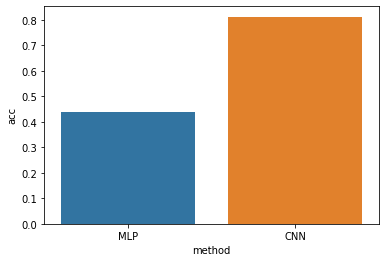

In [40]:
sns.barplot(data=result_df, x="method", y="acc")